In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

### Set Options

In [32]:
# Set whole=True if we want to analyze the new data and the old data together
whole = False

THRESHOLD = 80
batch_corrected = False
zero_remove = False
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(zero_remove)+'_'+str(scaler_term)
test_enc_name_new = '_Whole_'+str(whole)

### Load Config Files

In [33]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

### Get Data

In [64]:
data_new = pd.read_excel(os.path.join(data_path,"20240109_lipidomics_data.xlsx"),sheet_name='20240109_lipidomics_data')
if whole:
    data_old = pd.read_excel(os.path.join(data_path,"2022_12_Laezza_Mouse_Brain_deltamethrin_COMBINED_LIPIDOMICS_bc.xlsx"))

In [65]:
data_new.columns

Index(['Sample Number', 'LCMS Name', 'Replicate Number', 'Sample Group',
       'Group Number', 'Sample ID', 'Sex', 'Tissue Weight\n(mg)', 'Treatment',
       'Tissue', 'Lipid Name',
       'MRM Transition of each Lipid\n(Parent ion / Fragment ion)',
       'Lipid Class', 'Peak Area of Lipid ', 'RT',
       'Normalized Peak Area (Peak Area of Lipid/ (Peak Area of Internal Standard * Tissue weight))'],
      dtype='object')

#### -- We have to filter the old data extracting only males, striatum, PND30 --

In [66]:
if whole:
    data_old = data_old[data_old['Sex']=='M']
    data_old = data_old[data_old['Tissue Type']=='striatum']
    data_old = data_old[data_old['PND']==30]

### Rename the columns

In [67]:
columns_data = ['LCMS Name', 'Tissue Weight\n(mg)', 'Treatment', 'Lipid Name','Lipid Class','Normalized Peak Area (Peak Area of Lipid/ (Peak Area of Internal Standard * Tissue weight))']
columns_old = ['Sample Name', 'Tissue weight (mg)', 'Treatment', 'Individual Lipid Species', 'Lipid Class', 'Normalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue Weight))']
columns_new = ['name','weight','treatment','lipid','lipid_class','area']

data_new = data_new[columns_data]
data_new.columns = columns_new
data_new['batch']=1

if whole:
    data_old = data_old[columns_old]
    data_old.columns = columns_new
    data_old['batch']=0

if whole:
    data_all = pd.concat([data_new, data_old], axis=0)
    data_all = data_all[data_all['area']!=0]
else:
    data_all = data_new.copy()

data_temp = data_all[data_all['area'] != 0]
data_all['area'].replace(0,np.min(np.abs(data_temp['area'])), inplace=True)    
data_all['area'] = np.log(data_all['area'])

In [68]:
data_all = data_all[data_all['name'] != '20231228_Laezza_Lipidomics_PQC #6']

In [69]:
## number of samples

print(len(np.unique(data_all['name'])))

20


### Show some info (metabolites are less than the old data)

In [70]:
lipids_list = data_all['lipid'].nunique()
print(lipids_list)

1832


In [71]:
data_all.head()

,name,weight,treatment,lipid,lipid_class,area,batch
0,20231228_Laezza_Lipidomics_#1,106,control,CE(14:0),CE,-12.338462,1
1,20231228_Laezza_Lipidomics_#2,82,control,CE(14:0),CE,-12.338462,1
2,20231228_Laezza_Lipidomics_#3,92,control,CE(14:0),CE,-12.338462,1
3,20231228_Laezza_Lipidomics_#4,105,control,CE(14:0),CE,-12.338462,1
4,20231228_Laezza_Lipidomics_#5,100,control,CE(14:0),CE,-12.338462,1


### Organize PIVOT Table

In [72]:


data_pivot = data_all.pivot(index=['name', 'treatment'], columns='lipid', values=data_all.columns[-2])

data_pivot = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(1e-3*np.min(np.abs(data_all.iloc[:,-2])))

data_pivot['treatment'] = LabelEncoder().fit_transform(data_pivot['treatment'])

data_pivot.head()

lipid,name,treatment,CE(14:0),CE(16:0),CE(16:1),CE(18:0),CE(18:1),CE(18:2),CE(18:3),CE(20:0),...,TAG58:9-FA18:1,TAG58:9-FA18:2,TAG58:9-FA20:4,TAG58:9-FA22:5,TAG58:9-FA22:6,TAG60:10-FA22:5,TAG60:10-FA22:6,TAG60:11-FA22:5,TAG60:11-FA22:6,TAG60:12-FA22:6
0,20231228_Laezza_Lipidomics_#1,0,-12.338462,-5.316481,-4.673449,-12.338462,-3.863233,-4.406319,-12.338462,-12.338462,...,-4.817127,-12.338462,-3.721403,-5.121008,-3.107782,-4.873050,-2.354932,-4.045554,-2.918771,-1.584745
1,20231228_Laezza_Lipidomics_#10,0,-12.338462,-5.345409,-5.432992,-12.338462,-4.665982,-5.432992,-12.338462,-12.338462,...,-5.304335,-12.338462,-4.771225,-6.137647,-3.825845,-5.738374,-2.487711,-4.664920,-3.480241,-1.973281
2,20231228_Laezza_Lipidomics_#11,1,-12.338462,-4.967576,-6.413059,-12.338462,-4.546901,-4.619269,-12.338462,-12.338462,...,-4.957569,-12.338462,-3.649659,-5.499210,-3.414283,-5.025241,-2.422495,-4.297685,-2.837021,-1.456717
3,20231228_Laezza_Lipidomics_#12,1,-12.338462,-4.937850,-4.465408,-12.338462,-5.624048,-4.936456,-12.338462,-12.338462,...,-5.451469,-12.338462,-3.767923,-4.969014,-3.759302,-5.377361,-2.660690,-4.439656,-3.186893,-1.783791
4,20231228_Laezza_Lipidomics_#13,1,-12.338462,-6.092390,-4.335143,-12.338462,-4.518992,-5.190360,-12.338462,-12.338462,...,-5.432992,-12.338462,-4.268698,-5.381699,-3.676951,-5.001180,-2.638058,-4.414550,-2.933697,-1.951928


In [73]:
lipids_ok = list(data_pivot.columns[2:])
tot_lipids = len(lipids_ok)
tot_lipids

1832

In [74]:
data_pivot.columns[2:]

Index(['CE(14:0)', 'CE(16:0)', 'CE(16:1)', 'CE(18:0)', 'CE(18:1)', 'CE(18:2)',
       'CE(18:3)', 'CE(20:0)', 'CE(20:1)', 'CE(20:2)',
       ...
       'TAG58:9-FA18:1', 'TAG58:9-FA18:2', 'TAG58:9-FA20:4', 'TAG58:9-FA22:5',
       'TAG58:9-FA22:6', 'TAG60:10-FA22:5', 'TAG60:10-FA22:6',
       'TAG60:11-FA22:5', 'TAG60:11-FA22:6', 'TAG60:12-FA22:6'],
      dtype='object', name='lipid', length=1832)

### Dimensionality Reduction

In [75]:
from sklearn.cross_decomposition import PLSRegression

pls2_treatment = PLSRegression(n_components=20, scale = False)
pls2_date = PLSRegression(n_components=20, scale = False)
data_pls2_treatment = pls2_treatment.fit_transform(data_pivot.values[:,2:], data_pivot['treatment'].values)

c:\Users\ibern\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cross_decomposition\_pls.py:302: UserWarning: Y residual is constant at iteration 19
  warnings.warn(f"Y residual is constant at iteration {k}")


In [76]:
p_values_pls2 = [
    [
        d,
        ttest_ind(data_pls2_treatment[0][data_pivot['treatment']==0, d], data_pls2_treatment[0][data_pivot['treatment']==1, d])[1],
    ]
    for d in range(data_pls2_treatment[0].shape[1])
]
p_values_pls2 = np.asarray(p_values_pls2)
print(p_values_pls2.shape)

(20, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


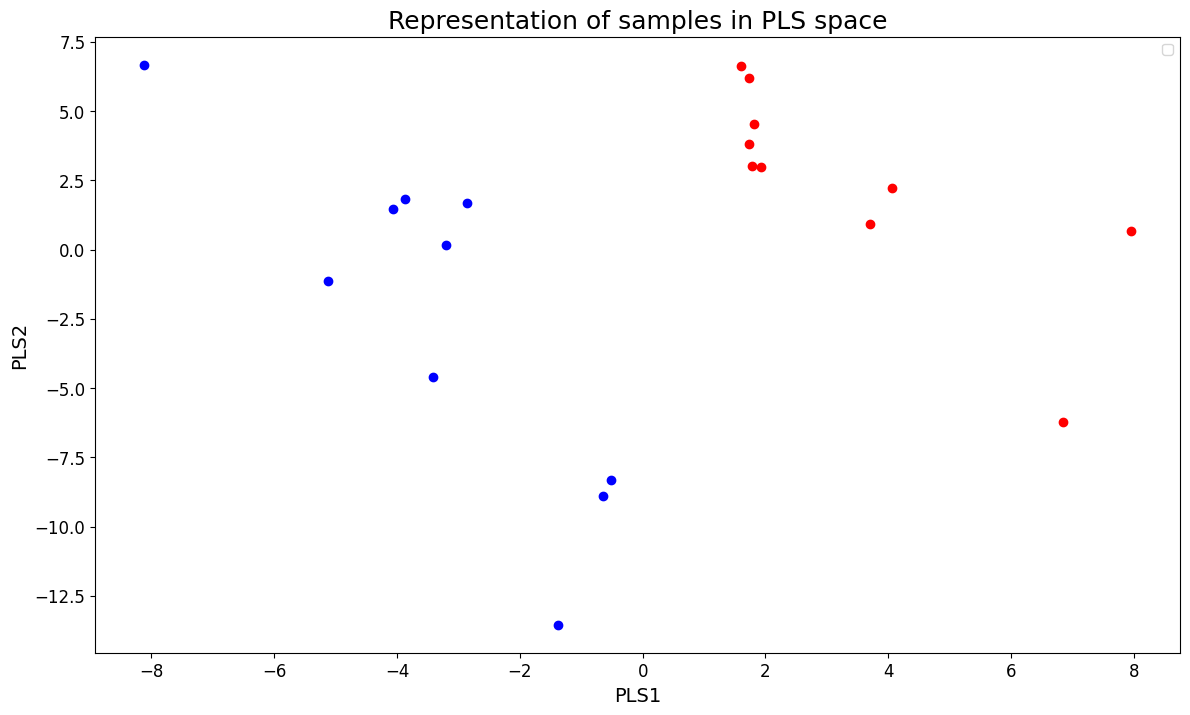

In [80]:
fig = plt.figure(figsize=(14,8))
plt.scatter(data_pls2_treatment[0][data_pivot['treatment']==0, 0], data_pls2_treatment[0][data_pivot['treatment']==0, 1],c="red")
plt.scatter(data_pls2_treatment[0][data_pivot['treatment']==1, 0], data_pls2_treatment[0][data_pivot['treatment']==1, 1],c="blue")
plt.legend()
plt.title('Representation of samples in PLS space', fontdict={'fontsize':18})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('PLS1', fontdict={'fontsize':14})
plt.ylabel('PLS2', fontdict={'fontsize':14})
fig.savefig(os.path.join(data_path,"mb-sample_distribution_PLS_space"+test_enc_name_new+".png"), format='png', facecolor='w', dpi=100)

In [78]:
print(f'{np.sum(p_values_pls2[:,1]<0.05)} significant pc with respect to TREATMENT')

significant_pc_pls2_treatment = np.where(p_values_pls2[:,1]<0.05)[0]
print(significant_pc_pls2_treatment)

2 significant pc with respect to TREATMENT
[0 1]


In [81]:
significant_components_pls2_treatment = pls2_treatment.x_weights_.T[significant_pc_pls2_treatment,:]
max_values_pls2_treatment = np.max(np.abs(significant_components_pls2_treatment), axis = 0)

In [82]:
ths_pls2_treatment = np.percentile(np.abs(pls2_treatment.x_weights_.T.flatten()), THRESHOLD)

In [84]:
tot_lipids = data_pivot.shape[1] - 2

In [86]:
idx_significant_lipids_pls2_treatment = np.where(max_values_pls2_treatment>ths_pls2_treatment)[0]
n_significant_lipids_pls2_treatment = len(idx_significant_lipids_pls2_treatment)
print(f'{n_significant_lipids_pls2_treatment} ({n_significant_lipids_pls2_treatment/tot_lipids*100:.2f}% of original total) significant metabolites found')
significant_lipids_pls2_treatment = [lipids_ok[i] for i in idx_significant_lipids_pls2_treatment]


653 (35.64% of original total) significant metabolites found


In [87]:
with open(os.path.join('results','significant_lipids_pls2_treatment'+test_enc_name_new+'.txt'), 'w+') as f:
    for l in significant_lipids_pls2_treatment:
        f.write(l+'\n')